In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

In [2]:
TICKERS = ['RELIANCE.NS','HDFCBANK.NS','BHARTIARTL.NS','ADANIPORTS.NS','ITC.NS','INFY.NS','TCS.NS','LICI.NS','LT.NS','HCLTECH.NS']
START = "2021-01-01"
END = "2025-01-01"
TRAIN_END = "2024-12-31"
PRED_START = "2025-01-01"
SEQ_LEN = 60
EPOCHS = 60
BATCH_SIZE = 32
RESULTS_DIR = "lstm_2025_predictions"
os.makedirs(RESULTS_DIR, exist_ok=True)


In [3]:
prices = yf.download(TICKERS, start=START, end=END, auto_adjust=True)["Close"]
prices = prices.ffill().dropna(how="all")

[*********************100%***********************]  10 of 10 completed


In [4]:
prices.index = pd.to_datetime(prices.index)
train_prices = prices.loc[prices.index <= pd.to_datetime(TRAIN_END)]
PRED_DAYS = 252

In [5]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.15))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.12))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer="adam", loss="mse")
    return model

In [6]:
def create_sequences(arr, seq_len):
    X, y = [], []
    for i in range(len(arr) - seq_len):
        X.append(arr[i:i+seq_len])
        y.append(arr[i+seq_len])
    X = np.array(X)
    y = np.array(y)
    return X.reshape((X.shape[0], X.shape[1], 1)), y


In [7]:
predicted_prices_2025 = pd.DataFrame(index=pd.RangeIndex(start=0, stop=PRED_DAYS), columns=TICKERS)
predicted_logreturns_2025 = pd.DataFrame(index=pd.RangeIndex(start=0, stop=PRED_DAYS), columns=TICKERS)

In [8]:
for ticker in TICKERS:
    print(f"\nProcessing {ticker} ...")
    series = train_prices[ticker].dropna().values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    series_scaled = scaler.fit_transform(series).flatten()

    X, y = create_sequences(series_scaled, SEQ_LEN)

    split_idx = int(0.9 * X.shape[0])
    X_tr, X_val = X[:split_idx], X[split_idx:]
    y_tr, y_val = y[:split_idx], y[split_idx:]

    model = build_lstm_model((SEQ_LEN, 1))
    es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=0)
    history = model.fit(X_tr, y_tr, validation_data=(X_val, y_val),
                        epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=0)
    print(f"  Trained {ticker}: epochs={len(history.history['loss'])}, final val_loss={history.history['val_loss'][-1]:.6e}")

    seed_scaled = series_scaled[-SEQ_LEN:].tolist()
    preds_scaled = []
    for i in range(PRED_DAYS):
        x_in = np.array(seed_scaled[-SEQ_LEN:]).reshape(1, SEQ_LEN, 1)
        yhat_scaled = model.predict(x_in, verbose=0)[0, 0]
        preds_scaled.append(yhat_scaled)
        seed_scaled.append(yhat_scaled)

    preds_price = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()
    predicted_prices_2025[ticker] = preds_price
    last_actual_price = series[-1, 0]
    prices_for_returns = np.concatenate(([last_actual_price], preds_price))
    logrets = np.log(prices_for_returns[1:] / prices_for_returns[:-1])
    predicted_logreturns_2025[ticker] = logrets

    print(f"  Predicted {PRED_DAYS} prices for 2025")


Processing RELIANCE.NS ...
  Trained RELIANCE.NS: epochs=60, final val_loss=1.263056e-03
  Predicted 252 prices for 2025

Processing HDFCBANK.NS ...
  Trained HDFCBANK.NS: epochs=43, final val_loss=3.902549e-03
  Predicted 252 prices for 2025

Processing BHARTIARTL.NS ...
  Trained BHARTIARTL.NS: epochs=33, final val_loss=1.539131e-03
  Predicted 252 prices for 2025

Processing ADANIPORTS.NS ...
  Trained ADANIPORTS.NS: epochs=21, final val_loss=2.007501e-03
  Predicted 252 prices for 2025

Processing ITC.NS ...
  Trained ITC.NS: epochs=20, final val_loss=7.442744e-04
  Predicted 252 prices for 2025

Processing INFY.NS ...
  Trained INFY.NS: epochs=12, final val_loss=9.747570e-03
  Predicted 252 prices for 2025

Processing TCS.NS ...
  Trained TCS.NS: epochs=60, final val_loss=1.578330e-03
  Predicted 252 prices for 2025

Processing LICI.NS ...
  Trained LICI.NS: epochs=23, final val_loss=1.993899e-03
  Predicted 252 prices for 2025

Processing LT.NS ...
  Trained LT.NS: epochs=33, fi

In [9]:
predicted_prices_2025.index.name = "day_index_2025"
predicted_logreturns_2025.index.name = "day_index_2025"
predicted_prices_2025.to_csv(os.path.join(RESULTS_DIR, "predicted_prices_2025.csv"))
predicted_logreturns_2025.to_csv(os.path.join(RESULTS_DIR, "predicted_logreturns_2025.csv"))
print(f"\nSaved predictions to {RESULTS_DIR}/predicted_prices_2025.csv and predicted_logreturns_2025.csv")
print("Done.")


Saved predictions to lstm_2025_predictions/predicted_prices_2025.csv and predicted_logreturns_2025.csv
Done.


In [10]:
tickers = ['RELIANCE.NS','HDFCBANK.NS', 'BHARTIARTL.NS','ADANIPORTS.NS','ITC.NS','INFY.NS','TCS.NS','LICI.NS','LT.NS','HCLTECH.NS']
data = yf.download(tickers, start='2024-01-01', end='2025-01-01', progress=False)

In [11]:
data.index.name = 'Date'
data = data.reset_index()
data.columns = ['Date' if col[0] == 'Date' else f"{col[0]}|{col[1]}" for col in data.columns]
data_melted = data.melt(id_vars='Date', var_name='Attribute_Ticker', value_name='value')
data_melted[['Attribute', 'Ticker']] = data_melted['Attribute_Ticker'].str.split('|', expand=True)
stock_data = data_melted.pivot_table(index=['Date', 'Ticker'],columns='Attribute',values='value',aggfunc='first').reset_index()
stock_data.columns.name = None

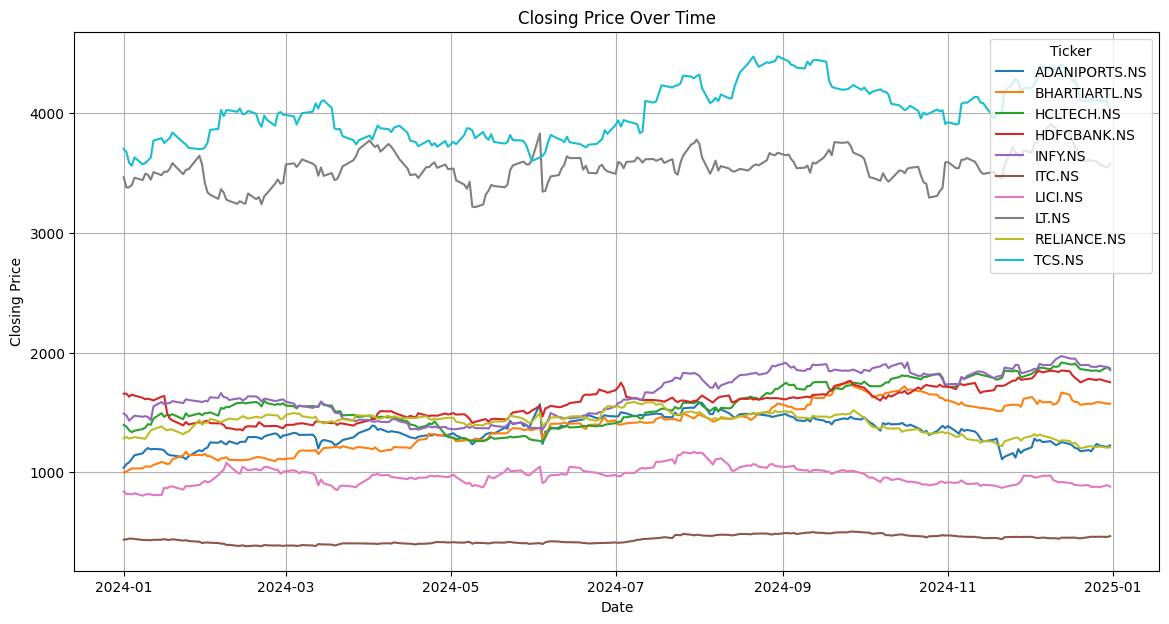

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

stock_data['Date'] = pd.to_datetime(stock_data['Date'])

stock_data.set_index('Date', inplace=True)
stock_data.reset_index(inplace=True)
plt.figure(figsize=(14, 7))

sns.lineplot(data=stock_data, x='Date', y='Close', hue='Ticker')
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(title='Ticker')
plt.grid(True)
plt.show()

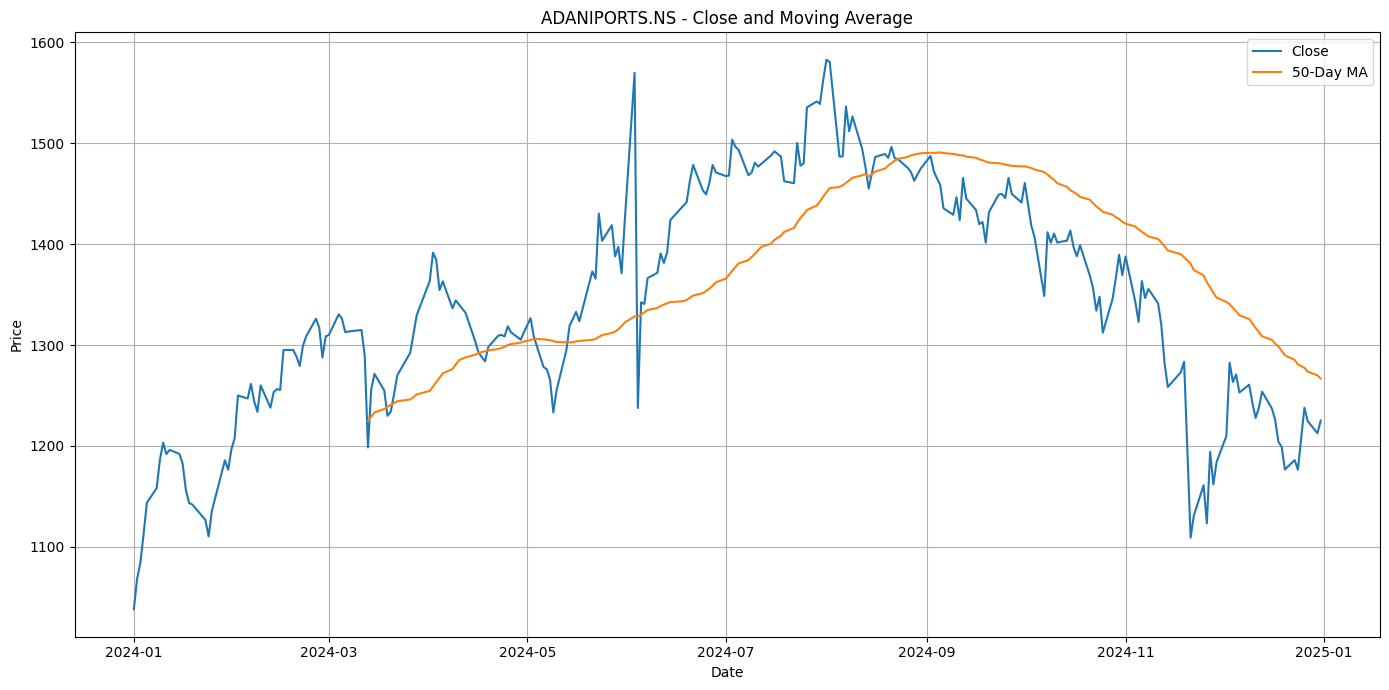

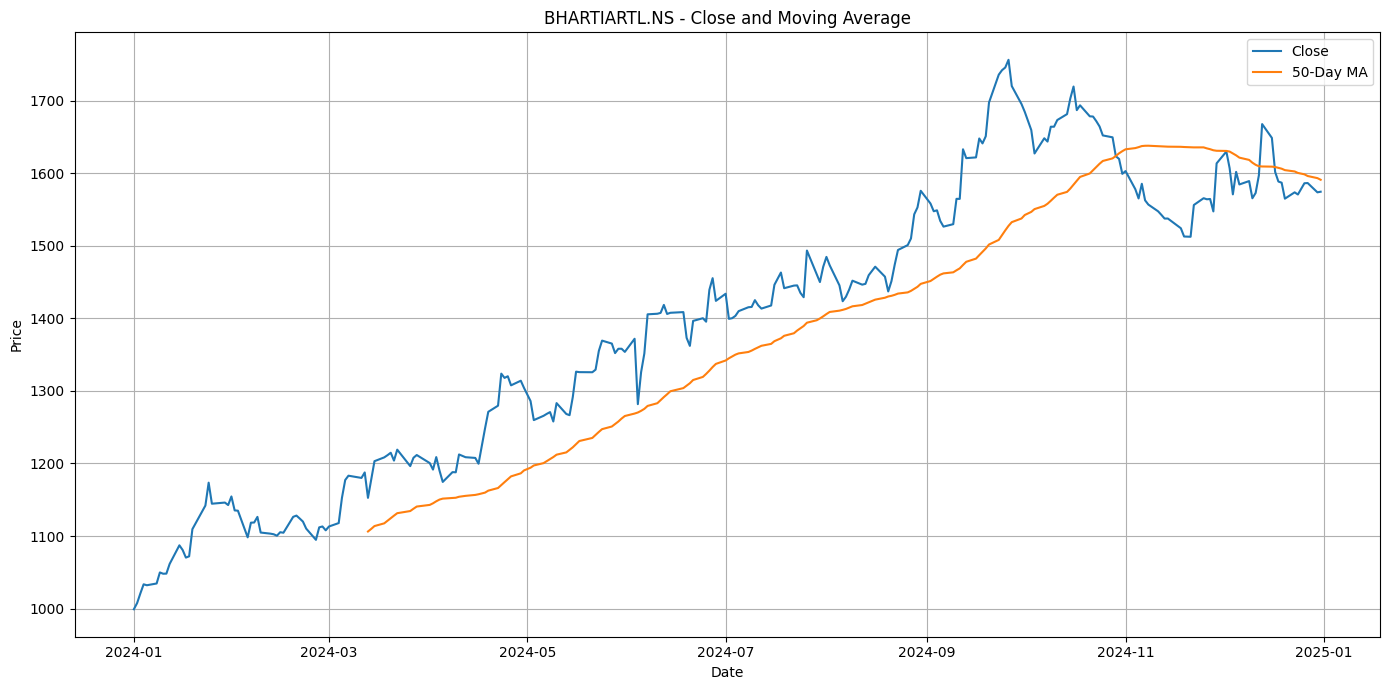

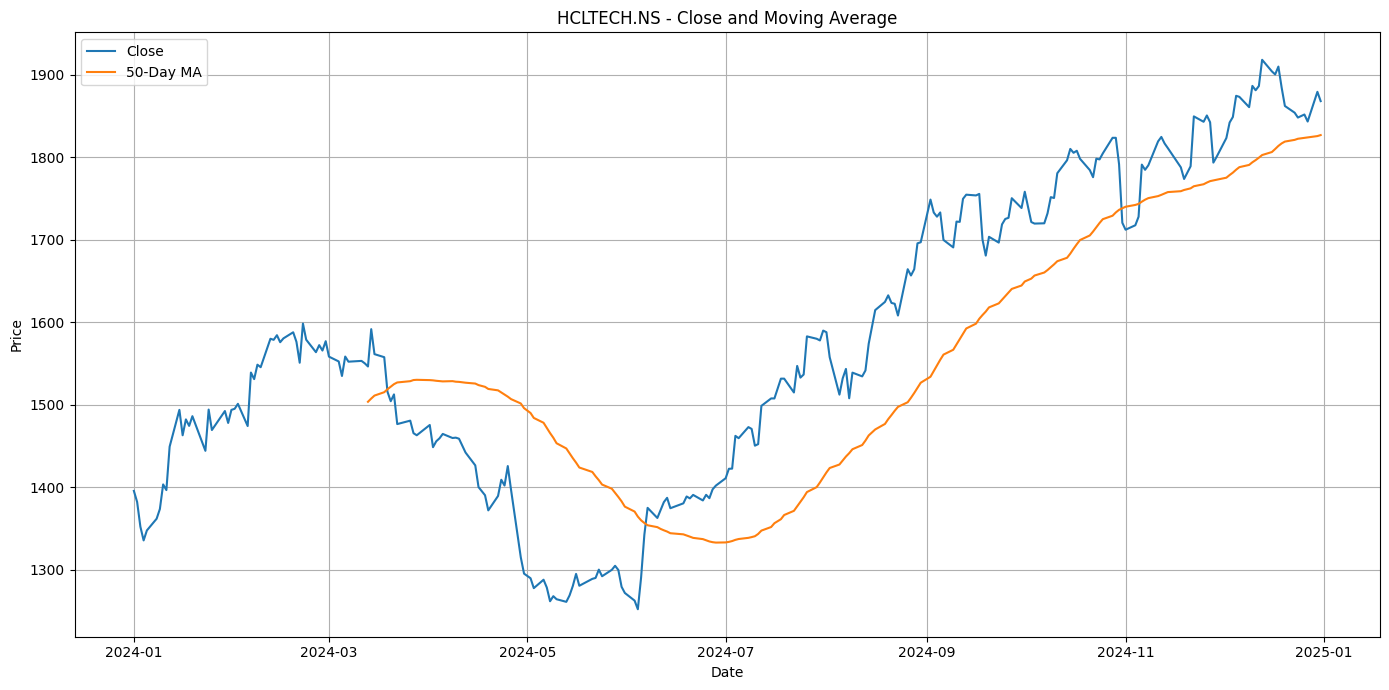

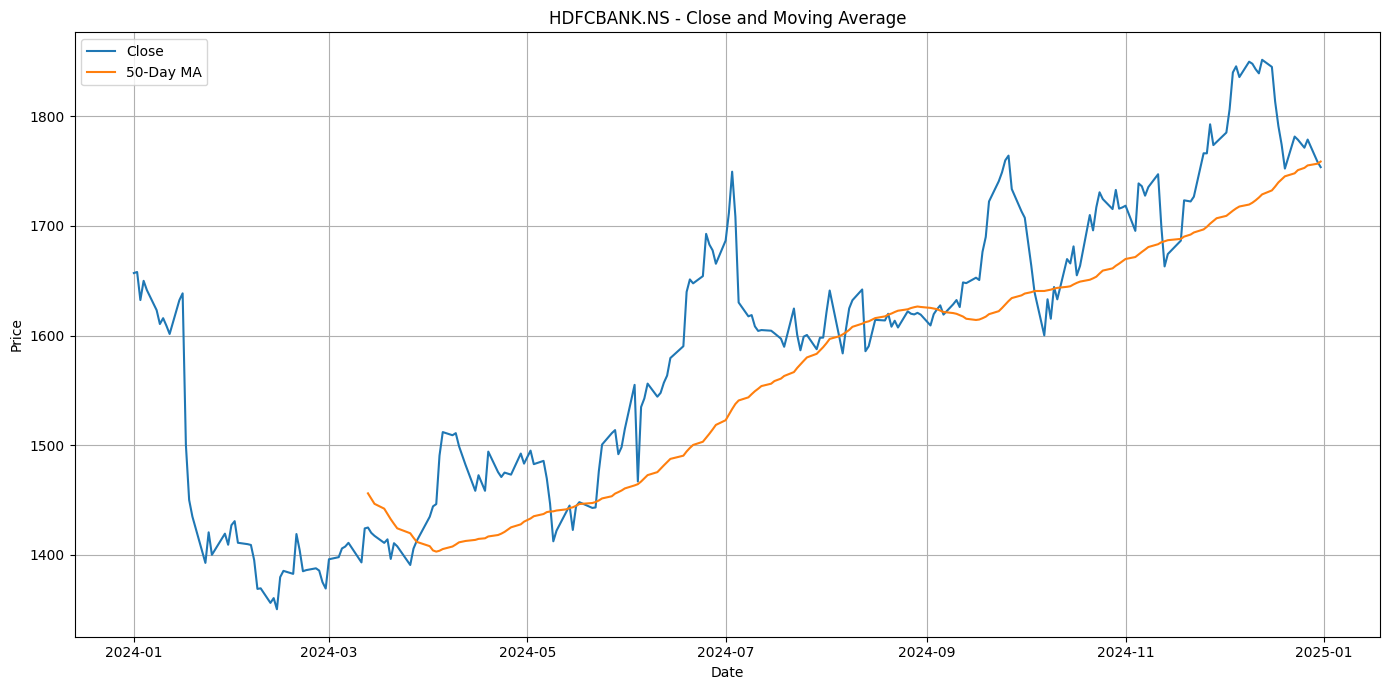

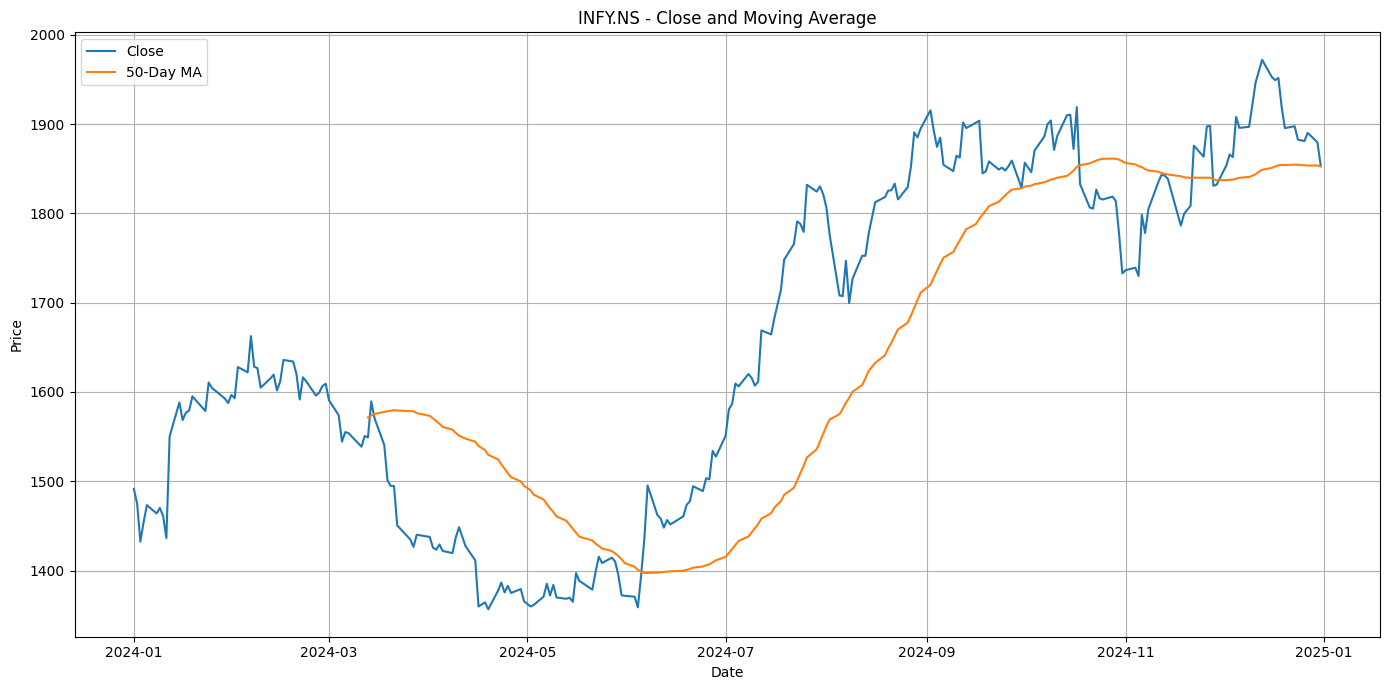

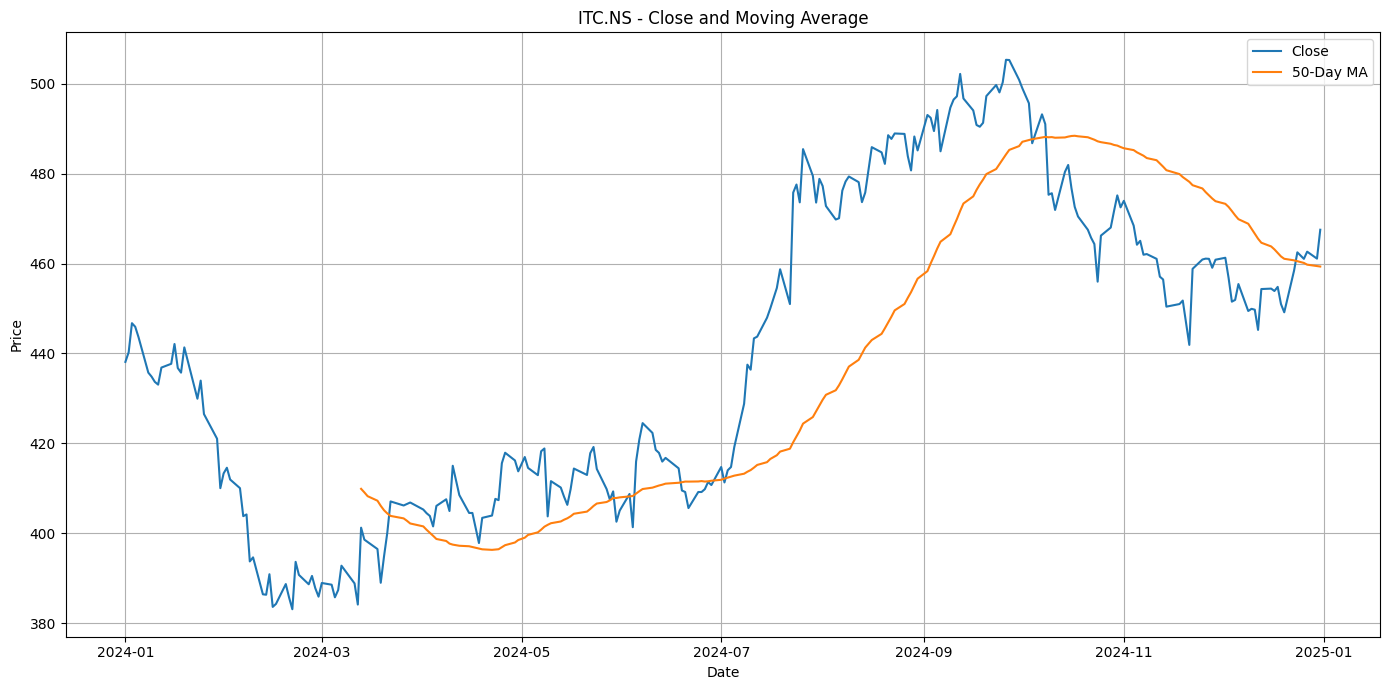

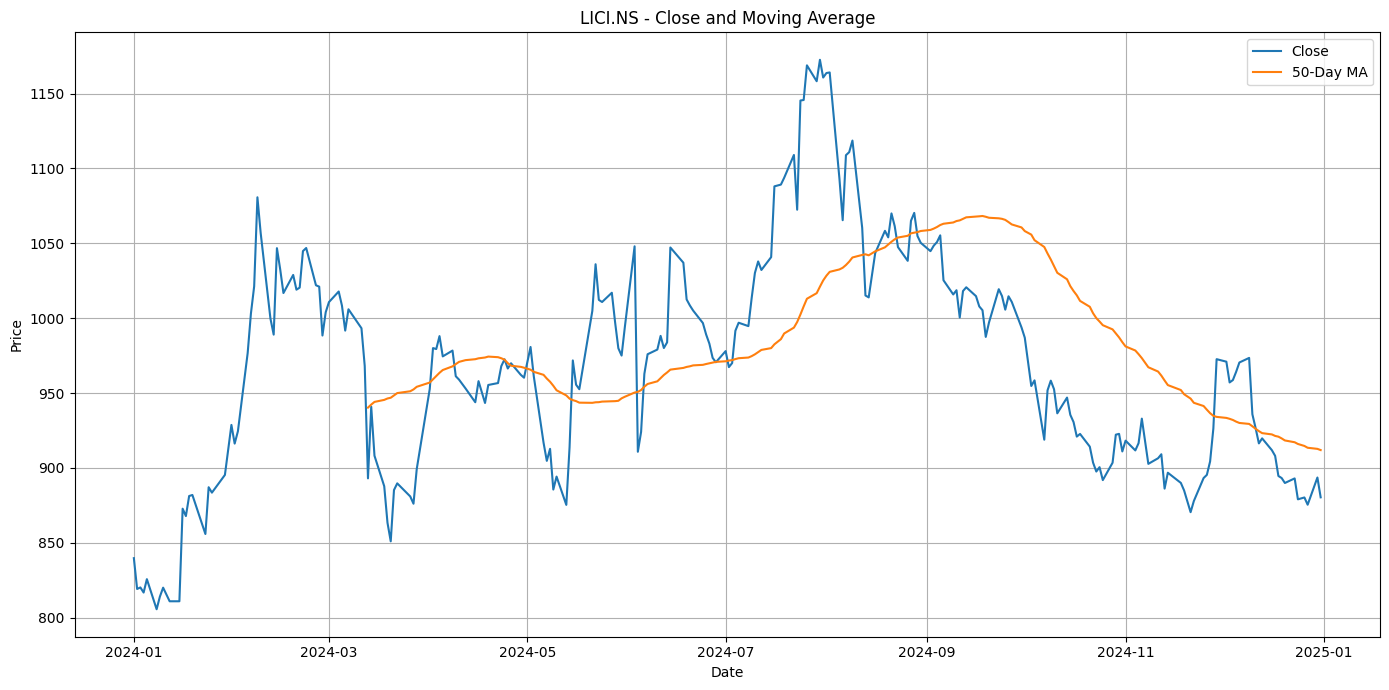

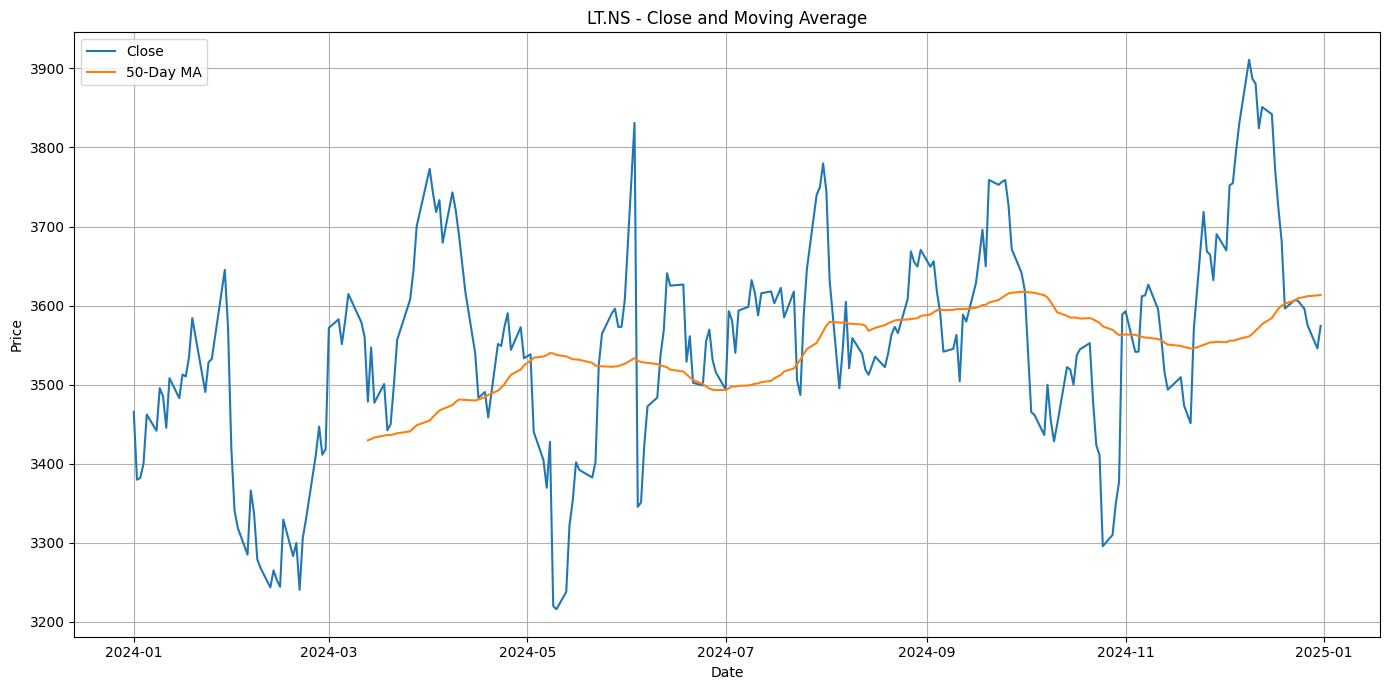

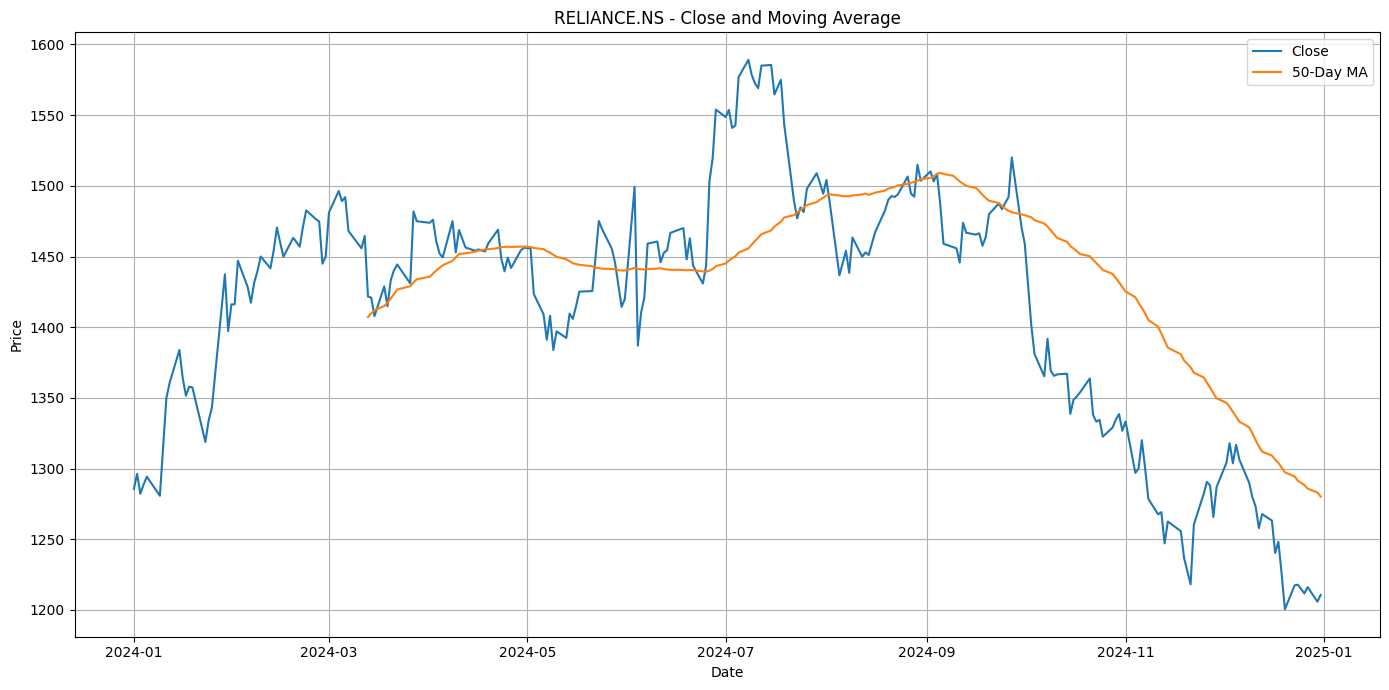

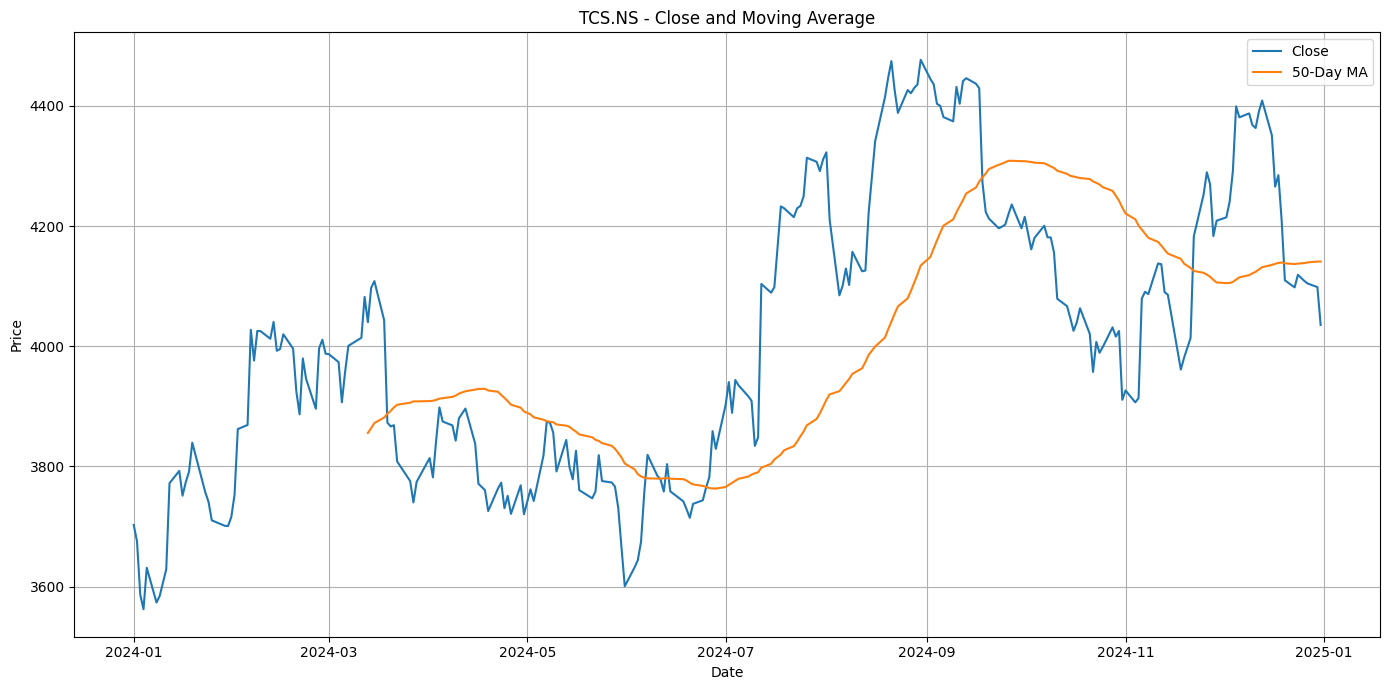

In [13]:
stock_data.set_index('Date', inplace=True)
unique_tickers = stock_data['Ticker'].unique()

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
    ticker_data['50_MA'] = ticker_data['Close'].rolling(window=50).mean()

    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data.index, ticker_data['Close'], label='Close')
    plt.plot(ticker_data.index, ticker_data['50_MA'], label='50-Day MA')
    plt.title(f'{ticker} - Close and Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

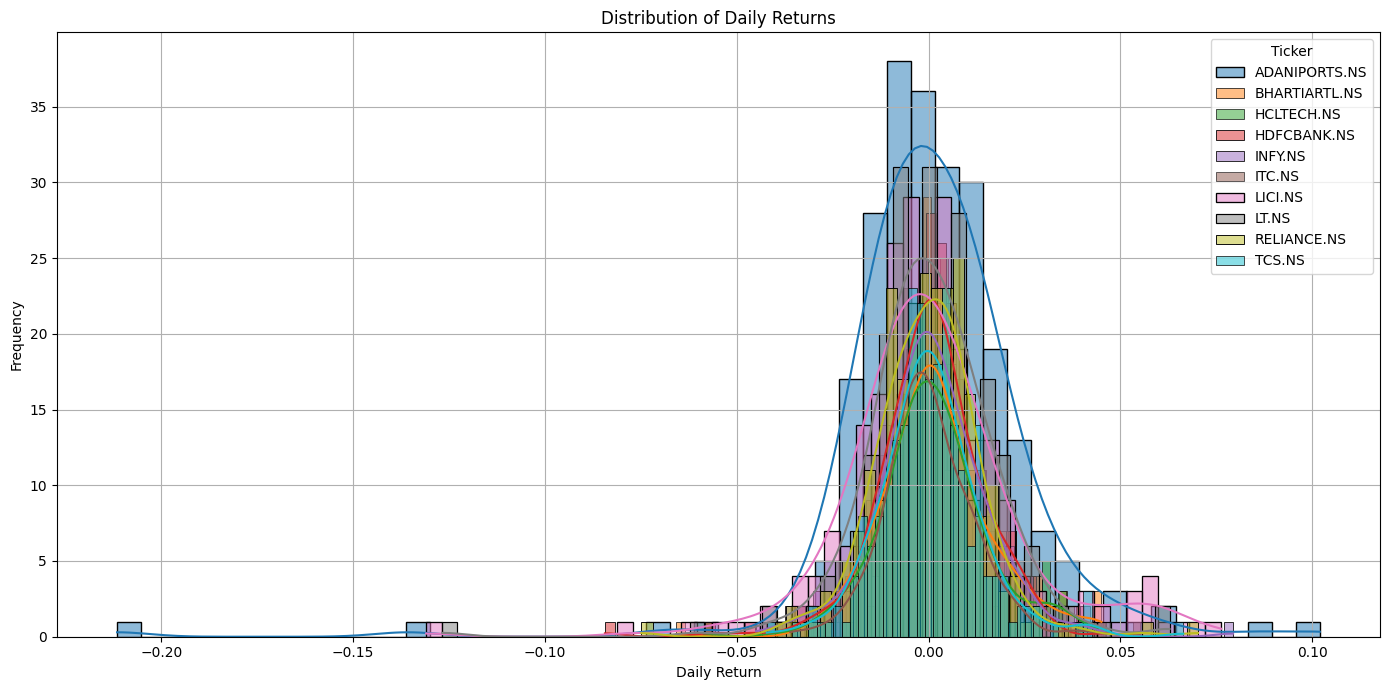

In [14]:
stock_data['Daily Return'] = stock_data.groupby('Ticker')['Close'].pct_change()

plt.figure(figsize=(14, 7))

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker]
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)

plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend(title='Ticker')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
daily_returns = stock_data.pivot_table(index='Date', columns='Ticker', values='Daily Return')
expected_returns = daily_returns.mean() * len(stock_data)/10
volatility = daily_returns.std() * np.sqrt(len(stock_data)/10)

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility
})

stock_stats

,Expected Return,Volatility
Ticker,,
ADANIPORTS.NS,0.250919,0.402532
BHARTIARTL.NS,0.483711,0.231121
HCLTECH.NS,0.317134,0.220549
HDFCBANK.NS,0.081546,0.221372
INFY.NS,0.243940,0.226374
ITC.NS,0.082541,0.186993
LICI.NS,0.115908,0.369760
LT.NS,0.070634,0.279740
RELIANCE.NS,-0.034743,0.226718


In [16]:
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

num_portfolios = 10000
results = np.zeros((3, num_portfolios))
cov_matrix = daily_returns.cov() * len(stock_data)/10
np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)
    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)
    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility

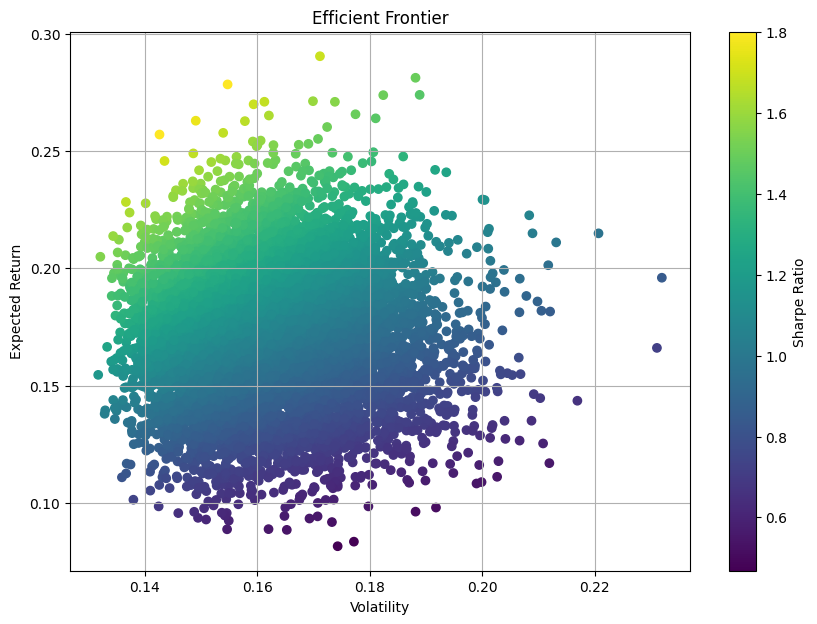

In [17]:
plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:])
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

In [18]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

In [19]:
max_sharpe_weights = np.zeros(len(unique_tickers))
np.random.seed(42)
for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(
        weights, expected_returns, cov_matrix
    )

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight%': max_sharpe_weights * 100
})

portfolio_weights_df.sort_values(by="Weight%", ascending=False, inplace=True)
portfolio_weights_df = portfolio_weights_df.head(4)

portfolio_weights_df["Weight%"] = (
    portfolio_weights_df["Weight%"] / portfolio_weights_df["Weight%"].sum() * 100
)

portfolio_weights_df.reset_index(drop=True, inplace=True)
portfolio_weights_df


,Ticker,Weight%
0,BHARTIARTL.NS,37.770456
1,HCLTECH.NS,26.490048
2,ITC.NS,20.212007
3,TCS.NS,15.527488


In [20]:
print(f"Maximum Returns: {max_sharpe_return * 100:.2f} %")
print(f"Volatility: {max_sharpe_volatility * 100:.2f} %")
print(f"Max Sharpe Ratio: {max_sharpe_ratio:.2f}")


Maximum Returns: 25.70 %
Volatility: 14.26 %
Max Sharpe Ratio: 1.80
